# Iteration 2 - Data Understanding after Data Preparation

> **Creator**: Ryo

In [1]:
import os
import itertools
import warnings

import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

### Variables

In [2]:
# Define the path to the folder containing the images to be processed
folder_path = '../data/data-understanding/2. Non Duplicated/'

---
## Load Images Data

### Load Image Paths From Source Folder

#### *Function*

In [3]:
def load_images_from_folder(folder_path, extensions=('.png', '.jpg', '.jpeg', '.JPG')):
    """
    Load all image file paths from a specified folder that match the given file extensions.

    Parameters:
    folder_path (str): The path to the folder containing the images.
    extensions (tuple of str): A tuple of file extensions to filter the images by. 
                                Default is ('.png', '.jpg', '.jpeg', '.JPG').

    Returns:
    list: A list of full file paths to images in the folder that match the specified extensions.
    
    Raises:
    FileNotFoundError: If the specified folder does not exist.
    """

    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The specified folder does not exist: {folder_path}")

    # List comprehension to gather all image paths with the specified extensions
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(extensions)]

    return image_paths

### Load & Pre-Process Image

#### *Function*

In [4]:
def load_and_preprocess_images(image_paths):
    """
    Load and preprocess a list of images by converting to grayscale without resizing.
    
    Parameters:
    image_paths (list): List of paths to image files.
    
    Returns:
    list: List of preprocessed images as numpy arrays (grayscale images).
    """
    images = []  # Initialize list to store preprocessed images

    # Initialize tqdm progress bar to track loading and processing of images
    for path in tqdm(image_paths, desc="Loading and preprocessing images", unit="image"):
        # Load the image from file
        img = cv2.imread(path)  
        
        # Check if the image is loaded successfully
        if img is None:
            print(f"Warning: Unable to load image at {path}")
            continue
        
        # Convert image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
        
        # Append the processed image to the list
        images.append(img_gray)  

    return images  # Return list of preprocessed images

In [5]:
def load_images(image_paths):
    """
    Load a list of original images without any preprocessing.
    
    Parameters:
    image_paths (list): List of paths to image files.
    
    Returns:
    list: List of original images as numpy arrays.
    """
    original_images = []  # Initialize list to store original images

    # Loop over each image path in the provided list
    for path in image_paths:
        img = cv2.imread(path)  # Load the original image from file
        original_images.append(img)  # Add the loaded image to the list

    return original_images  # Return list of original images

### Implementation

In [6]:
image_paths = load_images_from_folder(folder_path)

In [7]:
images = load_and_preprocess_images(image_paths)

Loading and preprocessing images: 100%|██████████| 633/633 [02:24<00:00,  4.39image/s]


---
## Statistical Analysis

### Brightness

In [8]:
def calculate_brightness(image):
    """
    Calculate the brightness of an image based on the mean pixel intensity.
    
    Parameters:
    image (numpy array): Input image as a numpy array. Should be in grayscale or 
                        single-channel format for accurate brightness calculation.
                        
    Returns:
    float: The average brightness of the image.
    """
    return np.mean(image)  # Calculate and return the mean pixel intensity

### Sharpness

In [9]:
def calculate_sharpness(image):
    """
    Calculate the sharpness of an image based on the variance of the Laplacian.
    
    Parameters:
    image (numpy array): Input image as a numpy array, preferably in grayscale 
                        for accurate sharpness calculation.
                        
    Returns:
    float: A sharpness score based on the variance of the Laplacian. 
            Higher values indicate sharper images.
    """
    # Apply Laplacian filter to the image and calculate its variance
    return cv2.Laplacian(image, cv2.CV_64F).var()  # Variance of Laplacian method


### Contrast

In [10]:
def calculate_contrast(image):
    """
    Calculate the contrast of an image based on the standard deviation of pixel values.
    
    Parameters:
    image (numpy array): Input image as a numpy array, preferably in grayscale.
    
    Returns:
    float: A contrast score based on the standard deviation of pixel values.
    """
    return image.std()  # Standard deviation of pixel values

### Noise

In [11]:
def calculate_noise(image):
    """
    Calculate the noise level of an image by analyzing the difference between
    the original and a blurred version.
    
    Parameters:
    image (numpy array): Input image as a numpy array.
    
    Returns:
    float: A noise score based on the variance of the difference between the 
            original and blurred images.
    """
    # Convert to grayscale if necessary
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to create a smoothed version of the image
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    
    # Calculate the absolute difference between the original and blurred images
    noise = cv2.absdiff(image, blurred)
    
    # Return the variance of the noise map as a measure of noise level
    return np.var(noise)

### Skew

In [12]:
def calculate_skew(image, max_lines=3):
    """
    Detect vertical lines in the image and calculate their average skew angle.
    
    Parameters:
    image (numpy array): Grayscale input image.
    max_lines (int): Maximum number of vertical lines to detect and include in calculations.
    
    Returns:
    float: 
        - Average skew angle in degrees between detected vertical lines and a perfectly vertical line.
    list:
        - Detected vertical lines in the format [(x1, y1, x2, y2), ...].
    """
    # Validate input image
    if len(image.shape) != 2:
        raise ValueError("Input image must be grayscale.")

    # Step 1: Adaptive thresholding for binary image
    binary = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )

    # Step 2: Morphological operations to enhance vertical lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 25))  # Vertical emphasis
    processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Step 3: Detect edges using Canny edge detection
    edges = cv2.Canny(processed, 50, 150, apertureSize=3)

    # Step 4: Hough Line Transform to detect vertical lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=80, minLineLength=100, maxLineGap=20)

    vertical_lines = []
    angles = []

    if lines is not None:
        for line in lines[:max_lines]:  # Limit to max_lines
            x1, y1, x2, y2 = line[0]

            # Calculate the angle of the line
            delta_x = x2 - x1
            delta_y = y2 - y1
            angle = np.arctan2(delta_y, delta_x) * 180 / np.pi  # Angle in degrees

            # Filter near-vertical lines (absolute angle close to 90°)
            if abs(angle) > 80:  # Close to vertical
                skew_angle = abs(90 - abs(angle))  # Calculate skew relative to 90°
                vertical_lines.append((x1, y1, x2, y2))
                angles.append(skew_angle)

    # Calculate the average skew angle
    average_skew = np.mean(angles) if angles else 0.0
    return round(average_skew, 2), vertical_lines

---
## Statistical Summary

### Create Statistics Table

#### *Function*

In [13]:
def image_statistics_table(images, image_paths):
    """
    Generate a table of essential statistics (brightness, sharpness, contrast, noise, skew) for a list of images.
    
    Parameters:
    images (list): List of image arrays.
    image_paths (list): List of image file names (not full paths) corresponding to each image.
    
    Returns:
    pd.DataFrame: DataFrame containing essential statistics for each image.
    """
    stats_data = {
        'Image': [], 
        'Brightness': [], 
        'Sharpness': [], 
        'Contrast': [], 
        'Noise': [], 
        'Skew': []
    }

    # Initialize tqdm progress bar for processing images
    for img, image_name in tqdm(zip(images, image_paths), desc="Processing Images", unit="image"):
        # Use the actual file name in the 'Image' column
        stats_data['Image'].append(image_name)
        
        # Validate the image
        if img is None or not isinstance(img, np.ndarray) or img.size == 0:
            # Append None for each statistic if the image is invalid
            for key in stats_data.keys():
                if key != 'Image':
                    stats_data[key].append(None)
            print(f"Warning: {image_name} is invalid or empty, setting values to None.")
            continue

        # Calculate and append each statistic to the stats_data dictionary
        stats_data['Brightness'].append(calculate_brightness(img))
        stats_data['Sharpness'].append(calculate_sharpness(img))
        stats_data['Contrast'].append(calculate_contrast(img))
        stats_data['Noise'].append(calculate_noise(img))
        skew, _ = calculate_skew(img)  # Only the skew value
        stats_data['Skew'].append(skew)
    
    # Create a DataFrame to store per-image statistics
    df = pd.DataFrame(stats_data)
    return df

### Overall Statistical Summary

#### *Function*

In [14]:
def overall_statistical_summary(df):
    """
    Calculate an overall statistical summary for selected features in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image statistics with columns such as
                    'Brightness', 'Sharpness', 'Contrast', 'Noise', and 'Skew'.
                    
    Returns:
    pd.DataFrame: A summary DataFrame with descriptive statistics for each feature.
    """
    # Select relevant columns for statistical summary
    columns_to_summarize = ['Brightness', 'Sharpness', 'Contrast', 'Noise', 'Skew']
    
    # Filter only existing columns to avoid errors
    available_columns = [col for col in columns_to_summarize if col in df.columns]
    
    if not available_columns:
        raise ValueError("No relevant columns available in the DataFrame for summary.")
    
    # Calculate summary statistics for the selected columns
    summary_df = df[available_columns].describe()
    
    return summary_df

### Implementation

#### *Create Data Table*

In [15]:
# Generate a statistics table using the list of image paths
df_stats = image_statistics_table(images, image_paths)

# Display the full statistics table for all images
print("Image Data Table:")
df_stats

Processing Images: 633image [13:58,  1.32s/image]


Image Data Table:


,Image,Brightness,Sharpness,Contrast,Noise,Skew
0,../data/data-understanding/2. Non Duplicated/c...,113.265481,15.666734,48.439169,0.542648,1.67
1,../data/data-understanding/2. Non Duplicated/c...,118.546299,12.971585,48.136750,0.455118,2.23
2,../data/data-understanding/2. Non Duplicated/c...,111.641777,11.282962,51.595790,0.406714,2.00
3,../data/data-understanding/2. Non Duplicated/c...,114.520743,13.814426,49.966408,0.485981,2.93
4,../data/data-understanding/2. Non Duplicated/c...,112.719509,13.423488,49.321008,0.479925,1.30
...,...,...,...,...,...,...
628,../data/data-understanding/2. Non Duplicated/c...,117.666171,24.931179,43.334404,0.868744,1.59
629,../data/data-understanding/2. Non Duplicated/c...,115.733136,38.464077,37.944293,1.631463,1.98
630,../data/data-understanding/2. Non Duplicated/c...,107.765204,49.437759,34.412749,1.898103,2.03
631,../data/data-understanding/2. Non Duplicated/c...,111.980041,87.210107,33.867067,3.370946,0.00


#### *Overall Statistics Table*

In [16]:
# Calculate and display the overall statistical summary
summary_df = overall_statistical_summary(df_stats)

print("\nOverall Statistical Summary:")
summary_df


Overall Statistical Summary:


,Brightness,Sharpness,Contrast,Noise,Skew
count,633.000000,633.000000,633.000000,633.000000,633.000000
mean,120.120884,18.622270,47.186072,0.675988,1.207378
std,6.059162,8.067944,5.083127,0.289091,0.898612
min,96.039227,6.487998,27.356893,0.261998,0.000000
25%,115.784504,12.960956,43.452850,0.470656,0.640000
50%,120.688518,16.063658,47.166476,0.587727,0.970000
75%,124.343369,24.198146,51.222289,0.863266,1.890000
max,161.166240,87.210107,71.578810,3.370946,5.270000


---
## Visualizations

### Characteristics Units

In [17]:
# Define characteristics and their units in a single dictionary
characteristics_units = {
    'Brightness': 'Pixel Value (0-255)',
    'Contrast': 'Pixel Value (0-255) Std Dev',
    'Sharpness': 'Pixel Intensity Variability',
    'Noise': 'Pixel Value (0-255) Std Dev',
    'Skew': 'Degrees (°)'
}

### General Characteristics Distribution

#### *Function*

In [18]:
def plot_characteristic_distribution(df, characteristic, unit, plot_type='hist'):
    """
    Visualize the distribution of a specific characteristic in a DataFrame using histograms or box plots.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    characteristic (str): The column name of the characteristic to plot.
    unit (str): The unit of the characteristic, for labeling purposes.
    plot_type (str): Type of plot to generate ('hist' for histogram, 'box' for box plot).
                    Default is 'hist'.
    
    Returns:
    None
    """
    # Set up figure size for consistent visualization
    plt.figure(figsize=(10, 6))

    # Generate histogram or box plot based on the specified plot type
    if plot_type == 'hist':
        sns.histplot(df[characteristic], kde=True, bins=30, color='blue')
    elif plot_type == 'box':
        sns.boxplot(x=df[characteristic], color='green')
    else:
        raise ValueError("Invalid plot_type. Choose 'hist' for histogram or 'box' for box plot.")

    # Customize the plot with titles and labels
    plt.title(f"Distribution of {characteristic}")
    plt.xlabel(f"{characteristic} ({unit})")
    plt.ylabel("Frequency")
    plt.grid(True)  # Add grid for better readability
    plt.show()  # Display the plot

#### *Implementation*

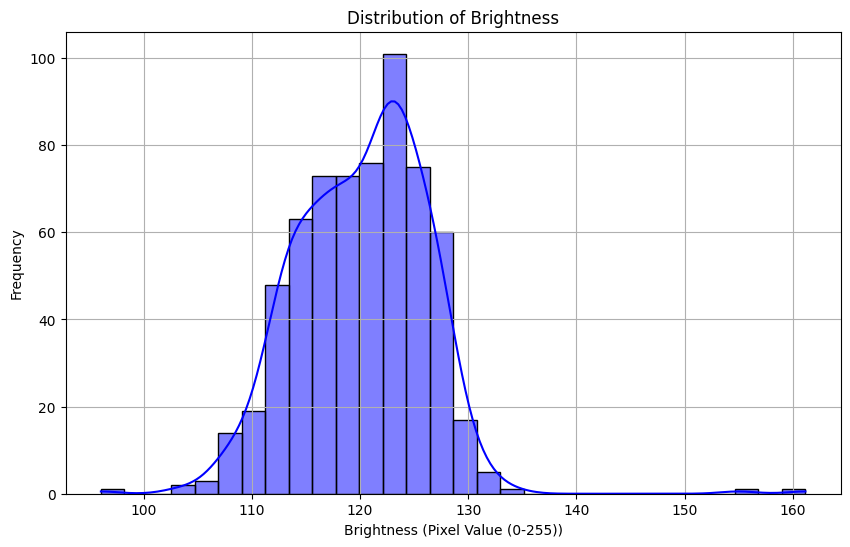

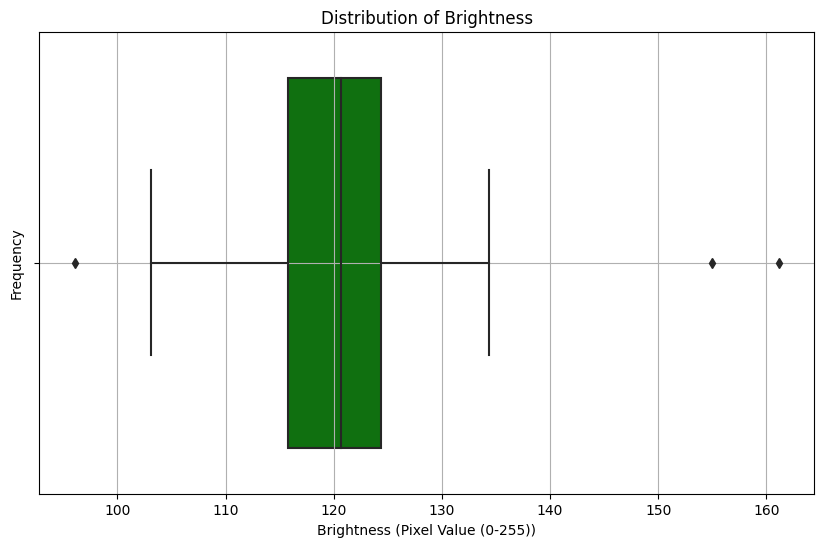

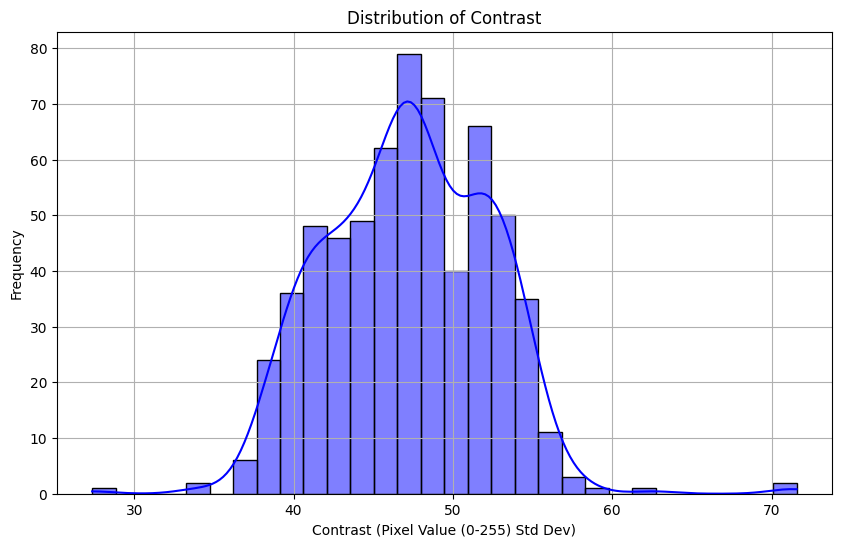

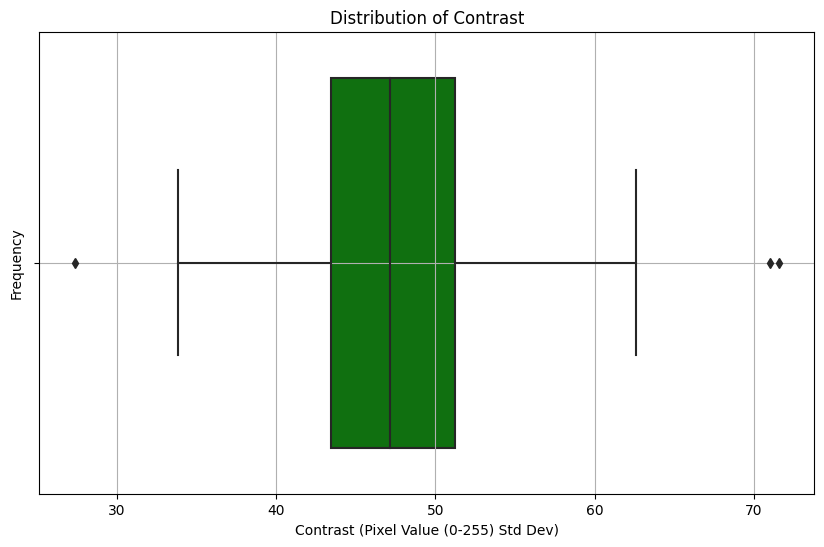

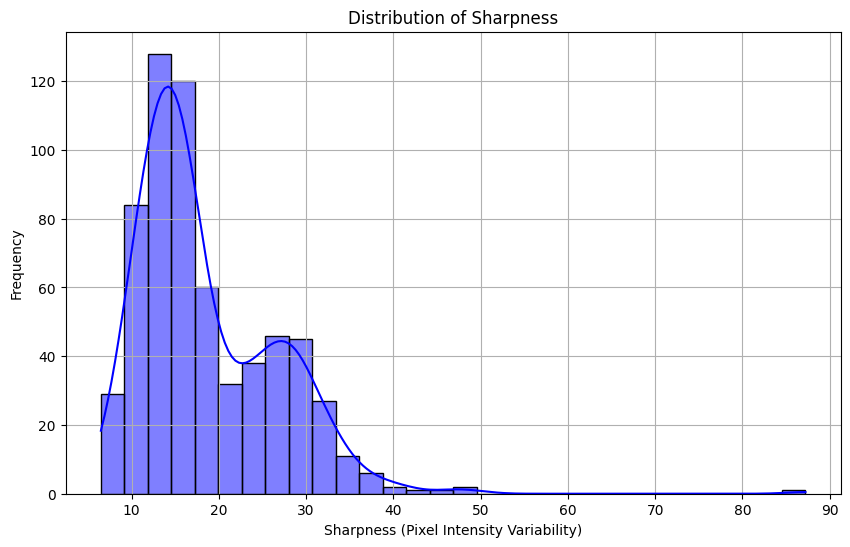

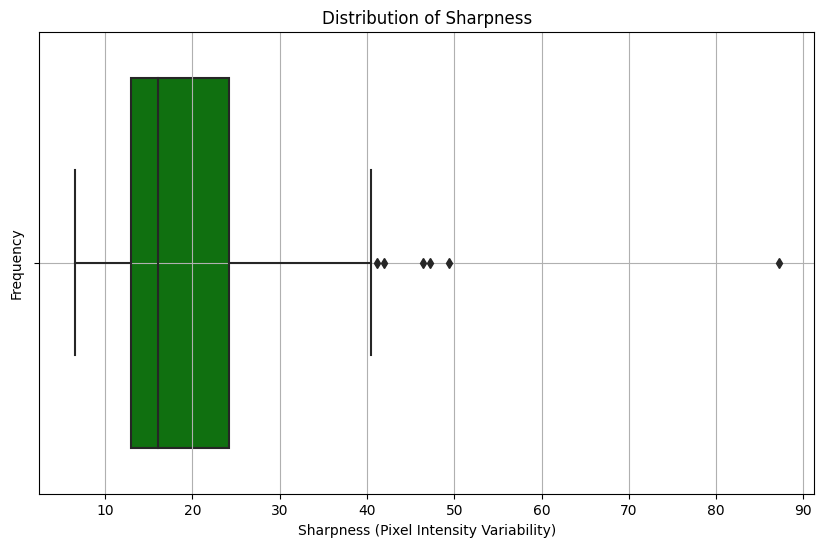

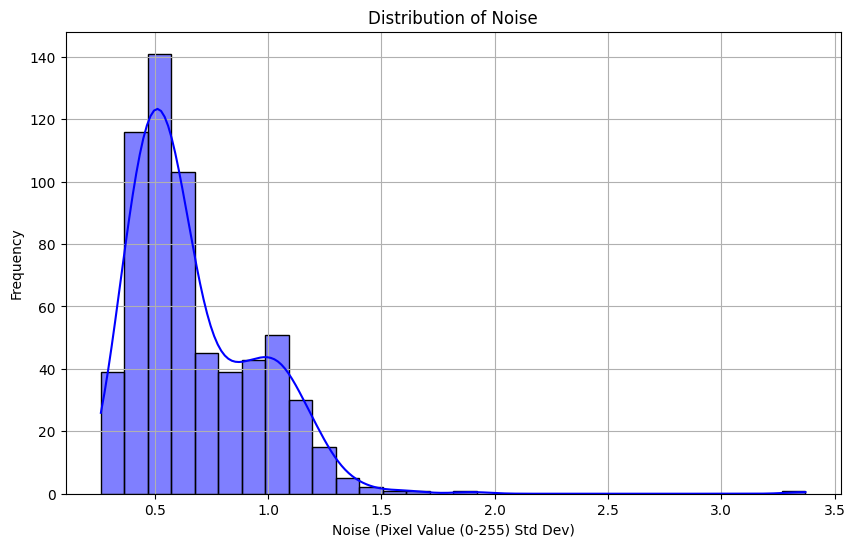

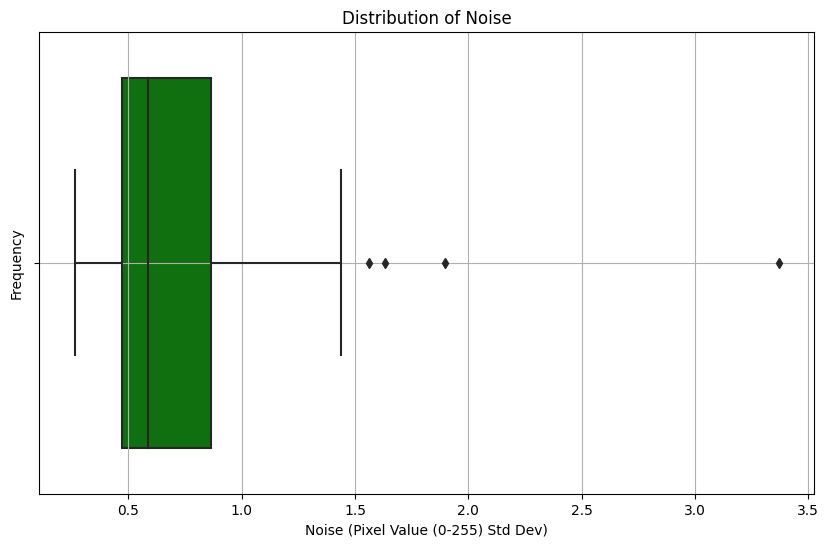

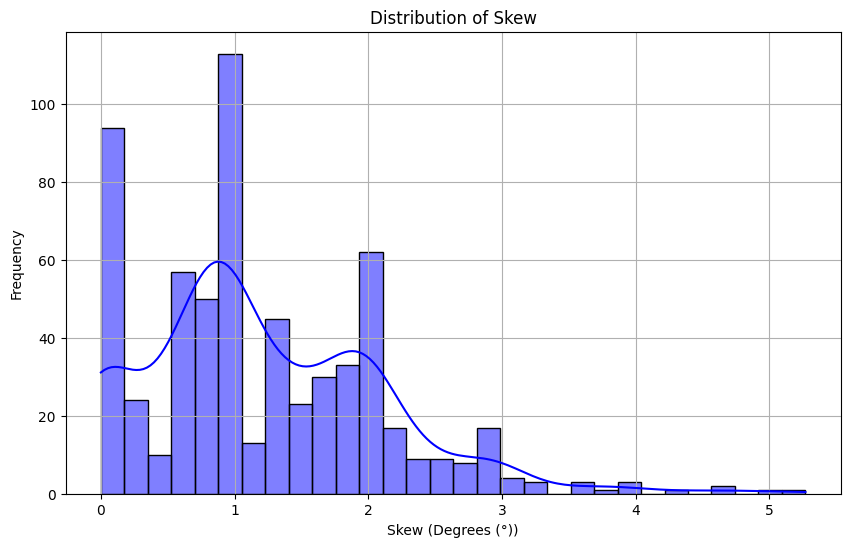

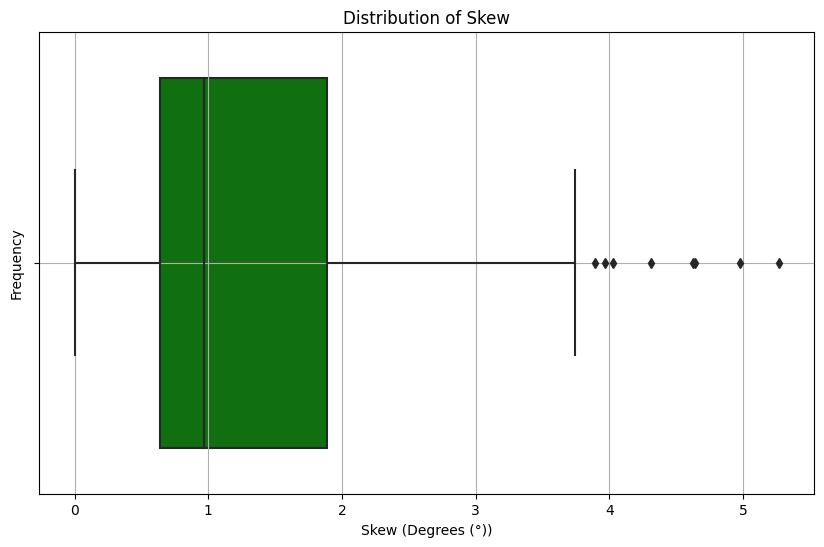

In [19]:
# Temporarily suppress FutureWarnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    
    # Loop through each characteristic and plot type
    for characteristic, unit in characteristics_units.items():
        for plot_type in ['hist', 'box']:
            # Plot the distribution for each characteristic using the specified plot type
            plot_characteristic_distribution(df_stats, characteristic, unit, plot_type)

### General Characteristics Relationship

#### *Function*

In [20]:
def plot_characteristic_relationship(df, characteristic_1, characteristic_2, unit_1, unit_2, use_color=False):
    """
    Plot the relationship between two characteristics in a DataFrame using scatter plots.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    characteristic_1 (str): The column name of the first characteristic (x-axis).
    characteristic_2 (str): The column name of the second characteristic (y-axis).
    unit_1 (str): The unit of the first characteristic, for x-axis labeling.
    unit_2 (str): The unit of the second characteristic, for y-axis labeling.
    use_color (bool): If True, color points by the values of `characteristic_2` to show variation.
                    Default is False.
    
    Returns:
    None
    """
    # Set up figure size for consistent visualization
    plt.figure(figsize=(10, 6))

    # Plot scatter plot with optional color encoding
    if use_color:
        sns.scatterplot(x=df[characteristic_1], y=df[characteristic_2], 
                        hue=df[characteristic_2], palette='coolwarm', s=50)
    else:
        sns.scatterplot(x=df[characteristic_1], y=df[characteristic_2], s=50)

    # Customize the plot with titles and labels
    plt.title(f"Relationship between {characteristic_1} and {characteristic_2}")
    plt.xlabel(f"{characteristic_1} ({unit_1})")
    plt.ylabel(f"{characteristic_2} ({unit_2})")
    plt.grid(True)  # Add grid for better readability
    plt.show()  # Display the plot

#### *Implementation*

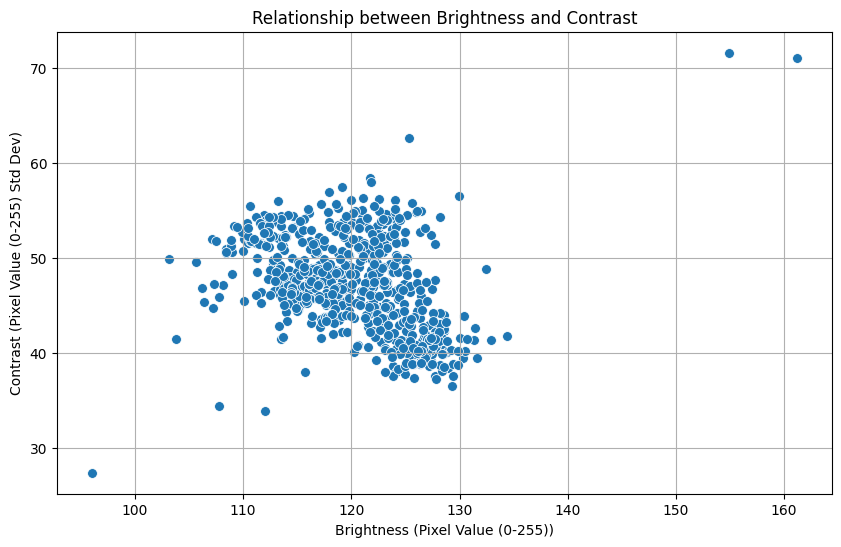

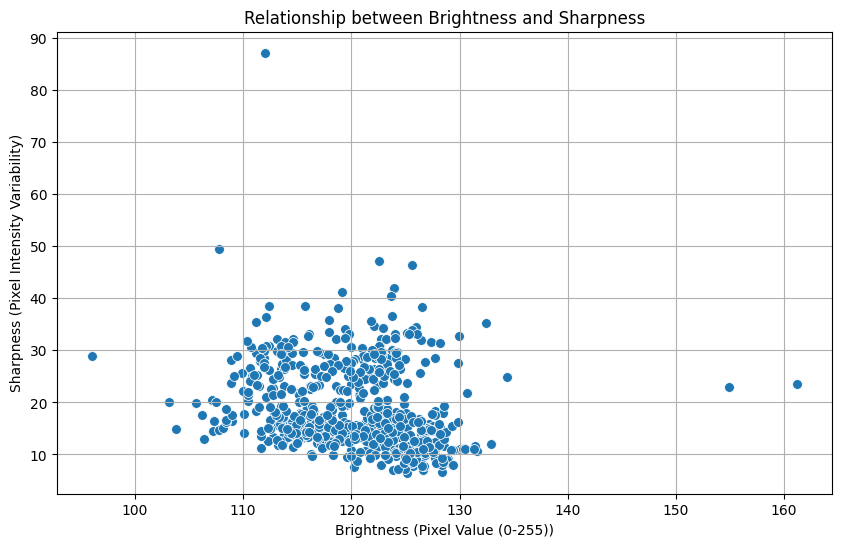

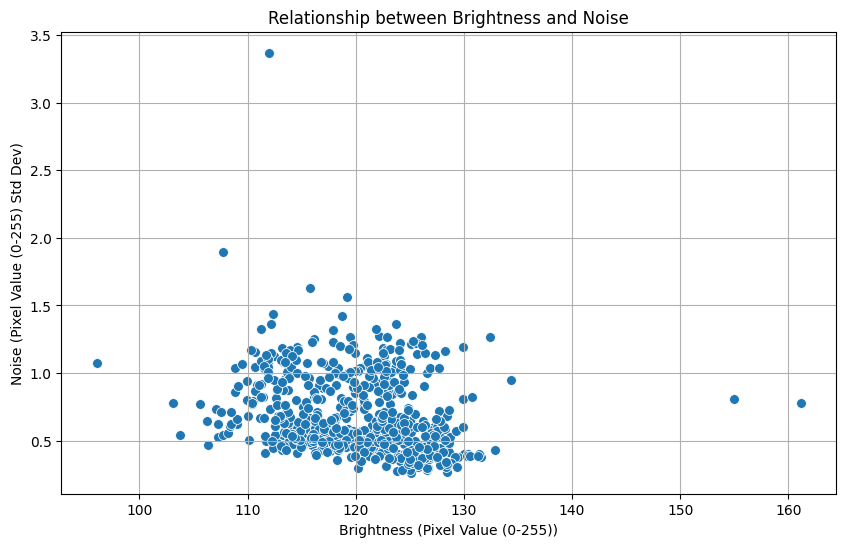

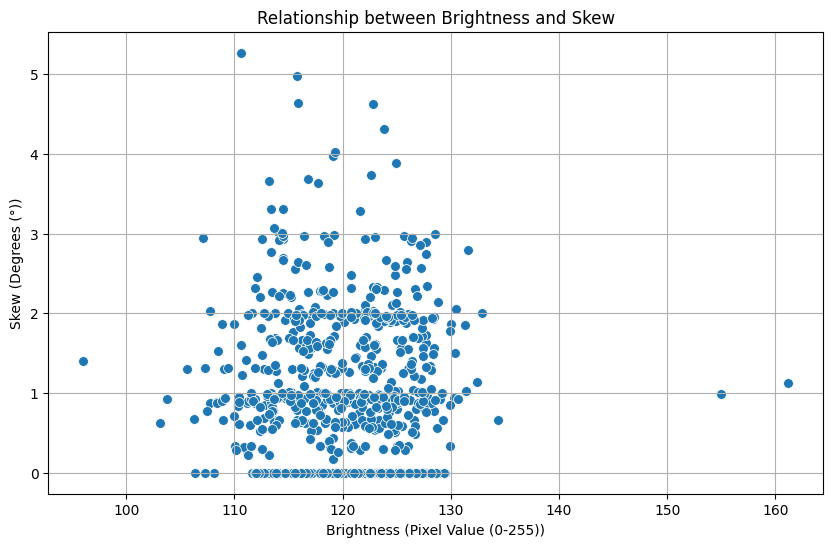

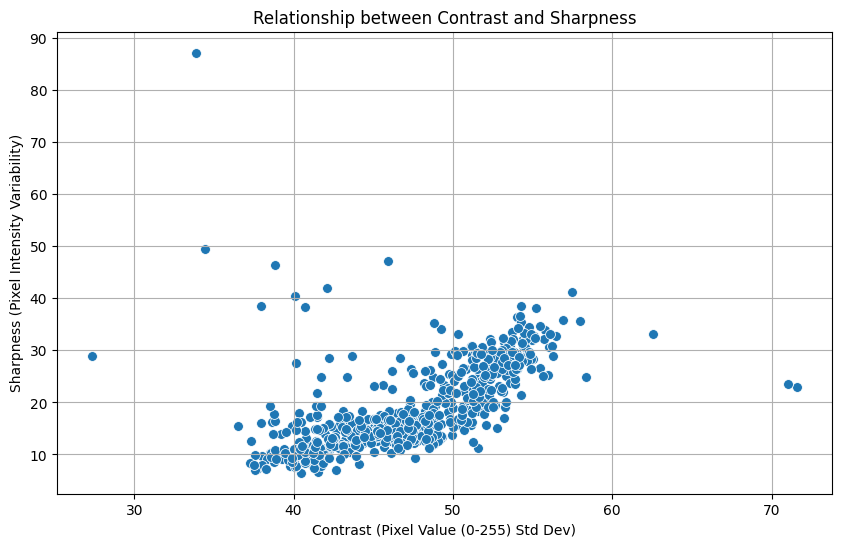

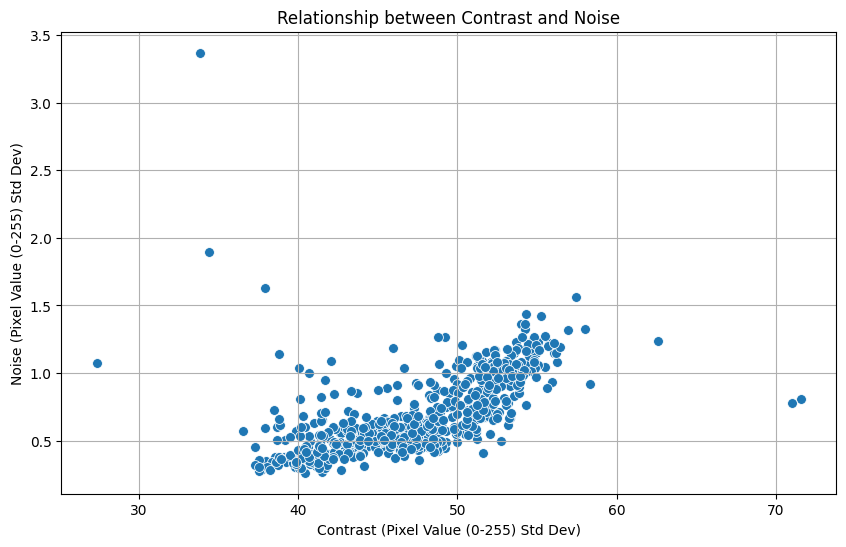

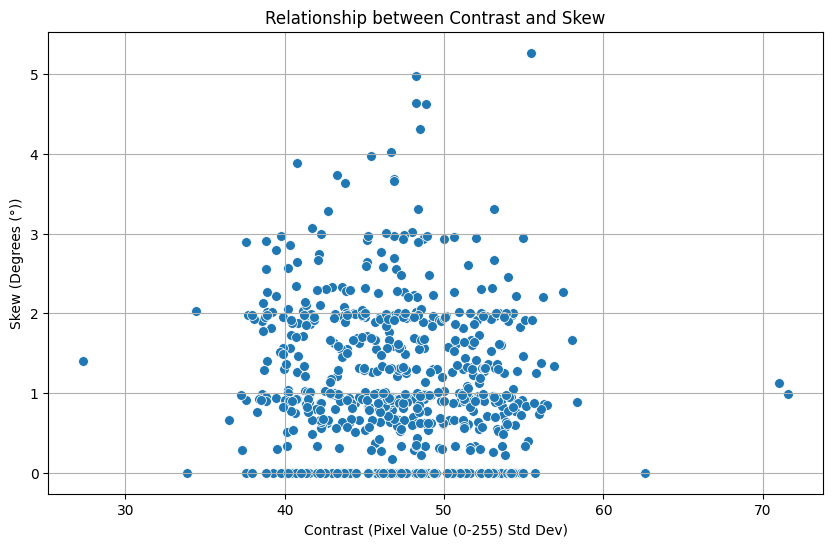

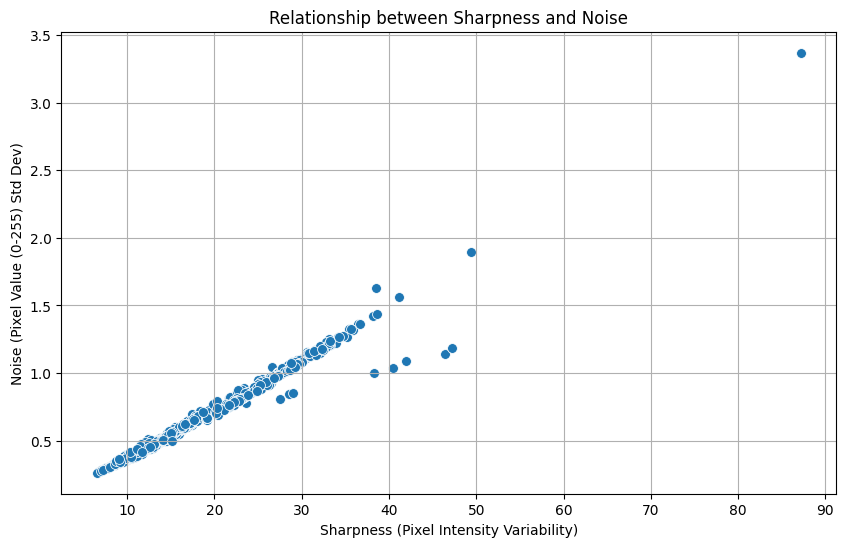

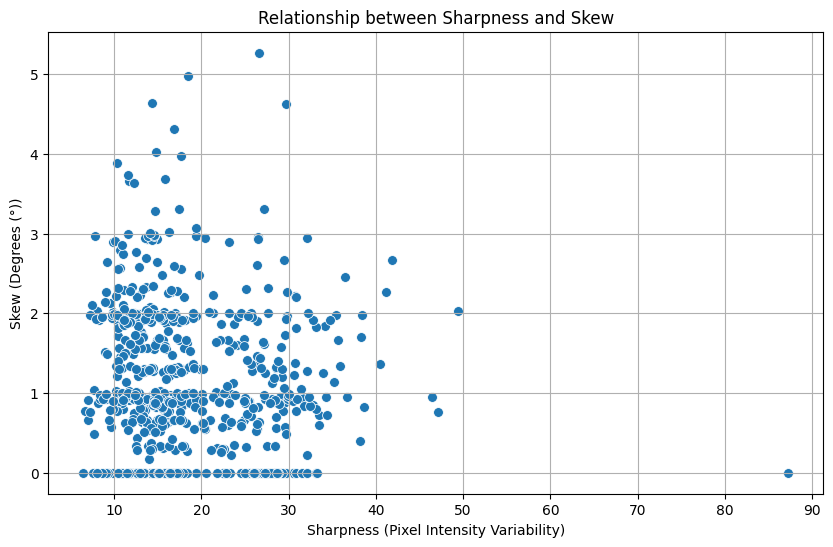

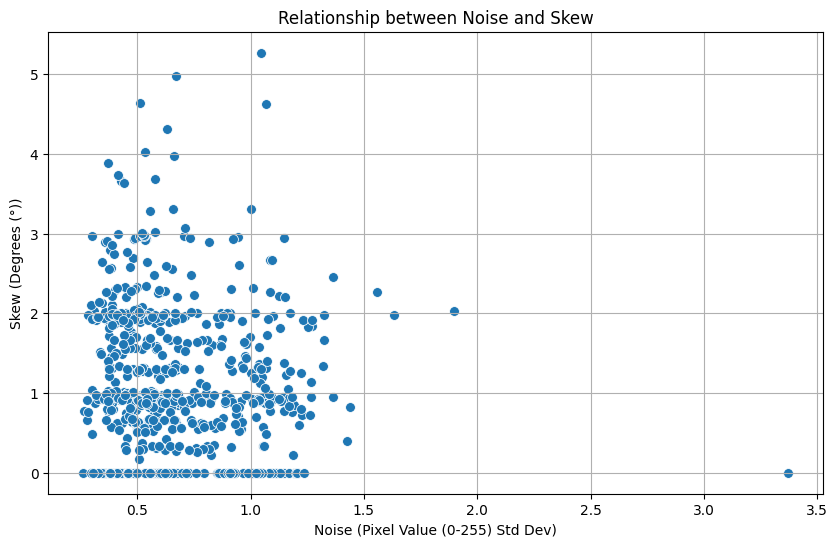

In [21]:
# Generate all possible pairs of characteristics for plotting relationships
pairs = itertools.combinations(characteristics_units.keys(), 2)

# Loop through each pair of characteristics and create relationship plots
for char1, char2 in pairs:
    plot_characteristic_relationship(
        df_stats,
        char1,
        char2,
        characteristics_units[char1],  # Retrieve unit for the first characteristic
        characteristics_units[char2]   # Retrieve unit for the second characteristic
    )

### Correlation Heatmap

#### *Function*

In [22]:
def plot_correlation_heatmap(df, characteristics, characteristic_units):
    """
    Create a heatmap to visualize correlations between different characteristics.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    characteristics (list of str): List of column names representing characteristics to include in the heatmap.
    characteristic_units (list of str): List of units corresponding to each characteristic.
    
    Returns:
    None
    """
    # Set figure size for visibility
    plt.figure(figsize=(10, 8))

    # Calculate the correlation matrix for the specified characteristics
    correlation_matrix = df[characteristics].corr()

    # Create annotations for the heatmap with correlation values and units
    annot = correlation_matrix.round(2).astype(str)  # Round to 2 decimal places and convert to string
    for i in range(len(characteristics)):
        for j in range(len(characteristics)):
            annot.iloc[i, j] += f"\n({characteristic_units[j]})"  # Append unit to each cell annotation

    # Generate the heatmap with annotations and a color map for visual clarity
    sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, fmt='',
                cbar_kws={'shrink': 0.8}, annot_kws={"size": 10})

    # Add plot titles and labels
    plt.title("Correlation Heatmap Between Characteristics", fontsize=16)
    plt.xlabel("Characteristics (Unit)", fontsize=14)
    plt.ylabel("Characteristics (Unit)", fontsize=14)

    # Customize tick labels with characteristic names and units, adjusting font size and rotation
    plt.xticks(ticks=range(len(characteristics)),
                labels=[f"{char} ({unit})" for char, unit in zip(characteristics, characteristic_units)],
                rotation=45, fontsize=12)
    plt.yticks(ticks=range(len(characteristics)),
                labels=[f"{char} ({unit})" for char, unit in zip(characteristics, characteristic_units)],
                rotation=0, fontsize=12)

    # Adjust layout to prevent clipping of tick labels
    plt.tight_layout()
    plt.show()

#### *Implementation*

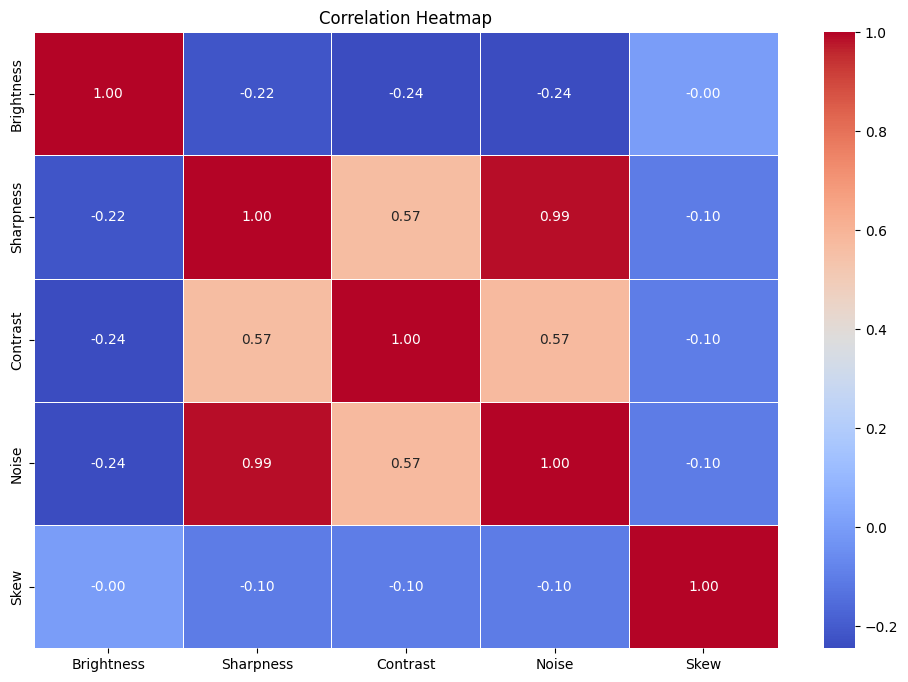

In [23]:
# Filter only numeric columns for correlation matrix and statistical tests
numeric_df = df_stats.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Statistical Tests

#### *Function*

In [24]:
def overall_statistical_tests(df):
    """
    Perform statistical tests on characteristics within a DataFrame, including normality tests 
    and Pearson correlation tests between characteristics.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing characteristics for statistical testing.
    
    Returns:
    pd.DataFrame: DataFrame containing the results of the statistical tests.
    """
    # Relevant characteristics
    relevant_columns = ['Brightness', 'Sharpness', 'Contrast', 'Noise', 'Skew']
    
    # Helper function for safe normality test
    def normality_test(column):
        try:
            stat, p_value = stats.normaltest(df[column].dropna())
            return 'Normality', column, None, stat, p_value
        except ValueError:
            return 'Normality (Skipped)', column, None, None, None
    
    # Helper function for safe Pearson correlation test
    def correlation_test(col1, col2):
        if df[col1].nunique() <= 1 or df[col2].nunique() <= 1:
            return 'Pearson Correlation (Skipped)', col1, col2, None, None
        corr_stat, corr_p_val = stats.pearsonr(df[col1].dropna(), df[col2].dropna())
        return 'Pearson Correlation', col1, col2, corr_stat, corr_p_val
    
    # Perform normality tests
    normality_results = [normality_test(col) for col in relevant_columns]

    # Perform Pearson correlation tests
    correlation_results = [
        correlation_test(col1, col2) for col1, col2 in itertools.combinations(relevant_columns, 2)
    ]
    
    # Combine results
    results = normality_results + correlation_results
    
    # Convert results to DataFrame
    return pd.DataFrame(results, columns=['Test', 'Characteristic_1', 'Characteristic_2', 'Statistic', 'P-Value'])

#### *Implementation*

In [25]:
# Perform overall statistical tests
test_results_table = overall_statistical_tests(numeric_df)
test_results_table

,Test,Characteristic_1,Characteristic_2,Statistic,P-Value
0,Normality,Brightness,None,88.683632,5.528330e-20
1,Normality,Sharpness,None,267.785464,7.097826e-59
2,Normality,Contrast,None,14.610907,6.718648e-04
3,Normality,Noise,None,323.085717,6.963506e-71
4,Normality,Skew,None,85.671544,2.492646e-19
5,Pearson Correlation,Brightness,Sharpness,-0.219731,2.326279e-08
6,Pearson Correlation,Brightness,Contrast,-0.244299,4.696892e-10
7,Pearson Correlation,Brightness,Noise,-0.244322,4.678719e-10
8,Pearson Correlation,Brightness,Skew,-0.000615,9.876889e-01
9,Pearson Correlation,Sharpness,Contrast,0.565901,7.162475e-55


---
## Special Visualization per Characteristics

In [26]:
# Pick a random image from the list of preprocessed images (assuming `images` is a list of grayscale images)
random_image = random.choice(images)

### Brightness

In [27]:
def plot_brightness_overall(df):
    """
    Plot the distribution of brightness across the entire dataset.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing brightness statistics for each image.
    
    Returns:
    None: Displays the brightness distribution plot for the dataset.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Brightness'], kde=True, bins=30, color='skyblue')
    plt.title("Distribution of Brightness Across Dataset")
    plt.xlabel("Brightness (Pixel Value 0-255)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [28]:
def plot_brightness_single(image):
    """
    Plot the brightness histogram for a single image and display the mean brightness value.
    
    Parameters:
    image (numpy array): Grayscale image to analyze brightness distribution.
    
    Returns:
    None: Displays the brightness histogram for the image.
    """
    # Calculate the mean brightness using the provided function
    mean_brightness = calculate_brightness(image)
    
    plt.figure(figsize=(10, 6))
    plt.hist(image.ravel(), bins=256, range=(0, 255), color='skyblue', alpha=0.7)
    plt.title(f"Brightness Histogram of Single Image (Mean Brightness: {mean_brightness:.2f})")
    plt.xlabel("Brightness (Pixel Value)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [29]:
def plot_brightness_heatmap(image):
    """
    Display a smoothed heatmap of brightness intensity for a single image using Gaussian blur,
    and display the mean brightness value in the title.
    
    Parameters:
    image (numpy array): Grayscale image to visualize brightness intensity.
    
    Returns:
    None: Displays a blurred heatmap visualization of the image's brightness.
    """
    # Calculate the mean brightness using the provided function
    mean_brightness = calculate_brightness(image)
    
    # Convert the image to float64 for accurate processing
    brightness_image = image.astype(np.float64)
    
    # Apply Gaussian blur to create a smooth brightness map
    blurred_brightness = cv2.GaussianBlur(brightness_image, (5, 5), 0)
    
    # Normalize the blurred brightness to fall between 0 and 255 for visualization
    brightness_heatmap = cv2.normalize(blurred_brightness, None, 0, 255, cv2.NORM_MINMAX)
    
    # Plot the smoothed heatmap with the mean brightness in the title
    plt.figure(figsize=(12, 12))
    plt.imshow(brightness_heatmap, cmap='gray', vmin=0, vmax=255)
    plt.colorbar(label="Brightness Intensity (Normalized 0-255)")
    plt.title(f"Brightness Heatmap of Image (Mean Brightness: {mean_brightness:.2f})")
    plt.axis('off')
    plt.show()

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


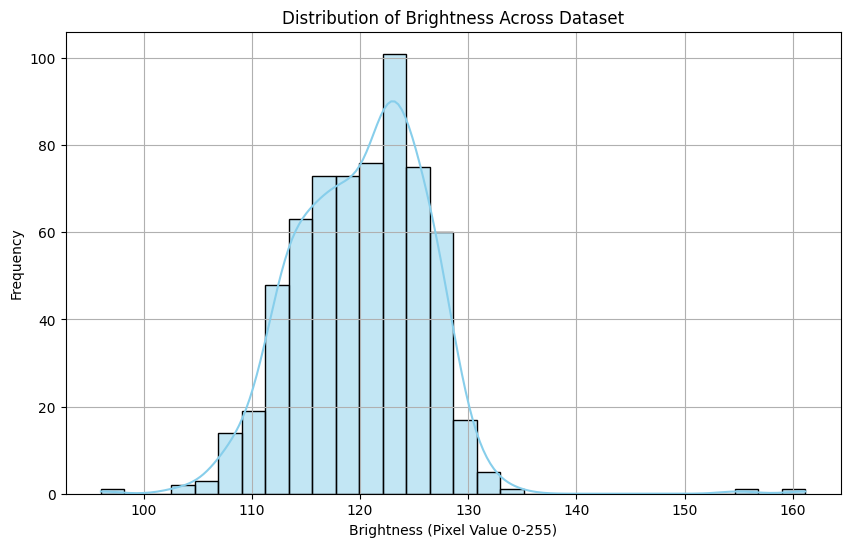

In [30]:
plot_brightness_overall(df_stats)

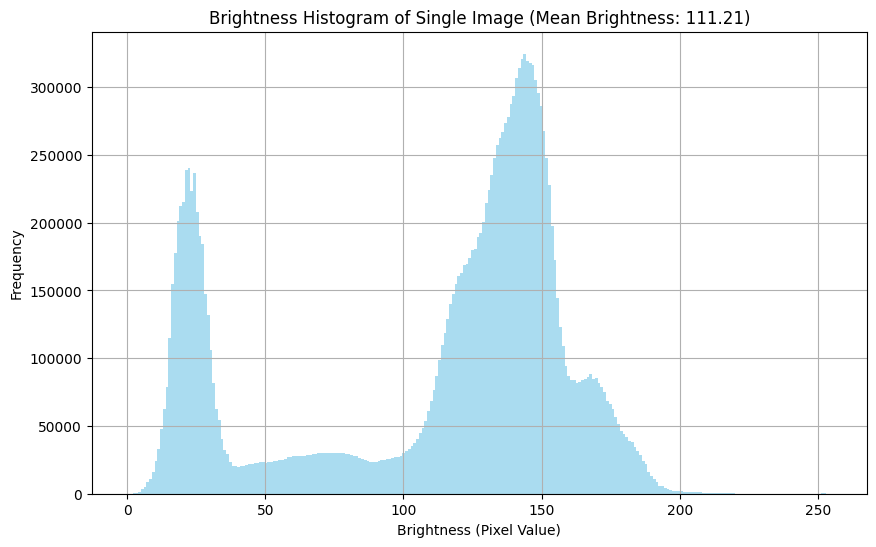

In [31]:
plot_brightness_single(random_image)

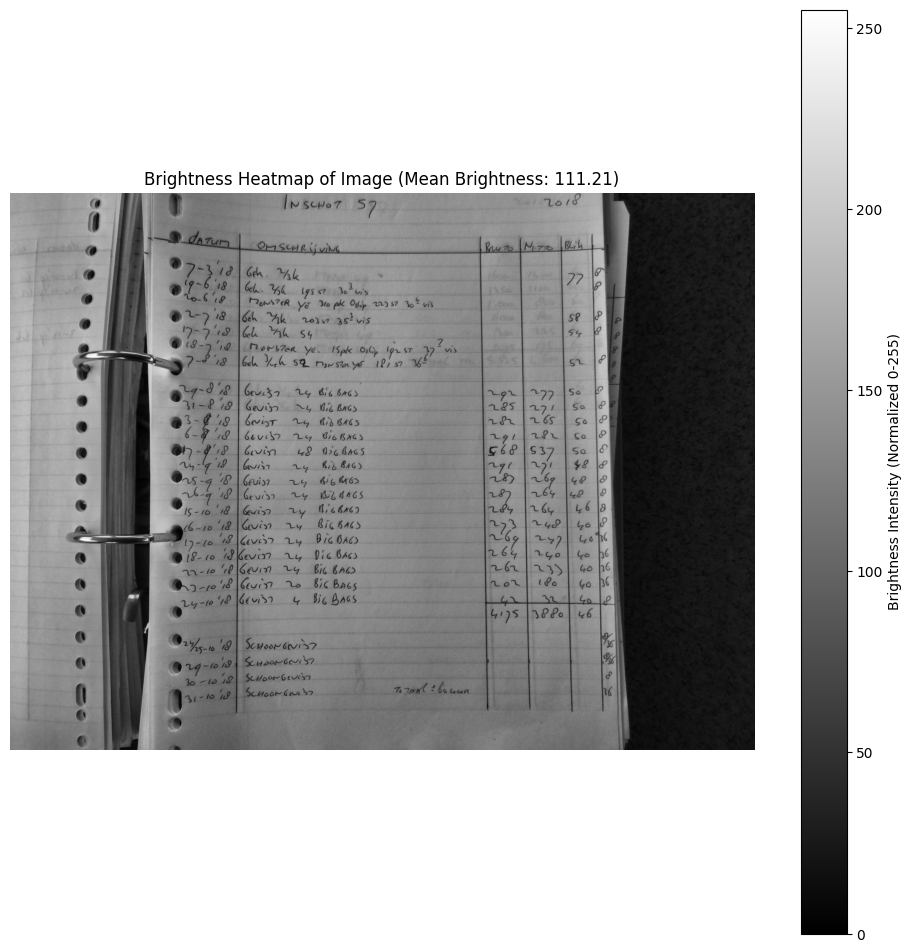

In [32]:
plot_brightness_heatmap(random_image)

### Contrast

In [33]:
def plot_contrast_overall(df):
    """
    Plot the distribution of contrast across the entire dataset.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing contrast statistics for each image.
    
    Returns:
    None: Displays the contrast distribution plot for the dataset.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Contrast'], kde=True, bins=30, color='purple')
    plt.title("Distribution of Contrast Across Dataset")
    plt.xlabel("Contrast (Pixel Value Std Dev)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [34]:
def plot_contrast_single(image):
    """
    Plot the contrast histogram for a single image and display the mean contrast value.
    
    Parameters:
    image (numpy array): Grayscale image to analyze contrast distribution.
    
    Returns:
    None: Displays the contrast histogram for the image.
    """
    # Calculate the mean contrast using the provided function
    mean_contrast = calculate_contrast(image)
    
    plt.figure(figsize=(10, 6))
    plt.hist(image.ravel(), bins=256, range=(0, 255), color='purple', alpha=0.7)
    plt.title(f"Contrast Histogram of Single Image (Mean Contrast: {mean_contrast:.2f})")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [35]:
def plot_contrast_map(image):
    """
    Display a contrast map for a single image by normalizing brightness values to enhance contrast,
    and display the mean contrast value in the title.
    
    Parameters:
    image (numpy array): Grayscale image to visualize contrast intensity.
    
    Returns:
    None: Displays a contrast map visualization of the image.
    """
    # Calculate the mean contrast using the provided function
    mean_contrast = calculate_contrast(image)
    
    # Normalize the image brightness to the range 0-255 to enhance contrast visibility
    contrast_map_normalized = cv2.normalize(image.astype(np.float64), None, 0, 255, cv2.NORM_MINMAX)
    
    # Plot the contrast map with the mean contrast in the title
    plt.figure(figsize=(6, 6))
    plt.imshow(contrast_map_normalized, cmap='gray', vmin=0, vmax=255)
    plt.colorbar(label="Contrast Intensity (Normalized 0-255)")
    plt.title(f"Contrast Map of Image (Mean Contrast: {mean_contrast:.2f})")
    plt.axis('off')
    plt.show()

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


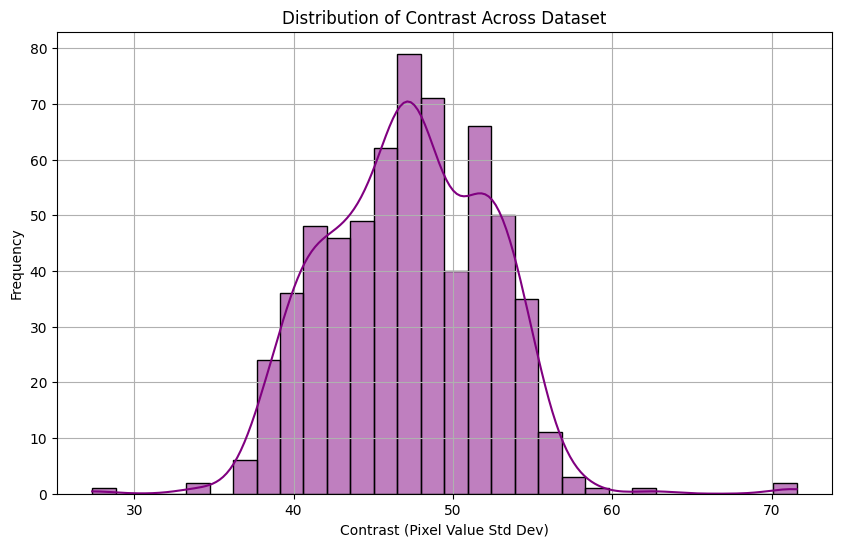

In [36]:
plot_contrast_overall(df_stats)

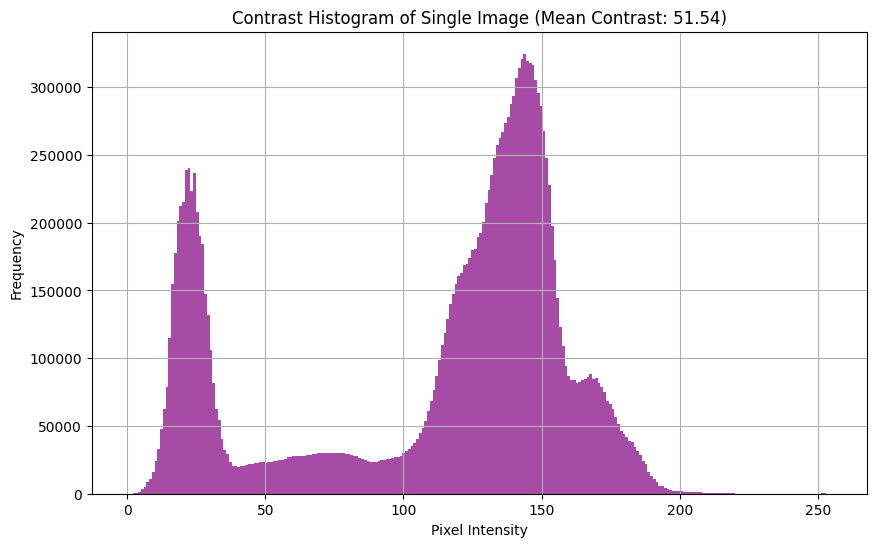

In [37]:
plot_contrast_single(random_image)

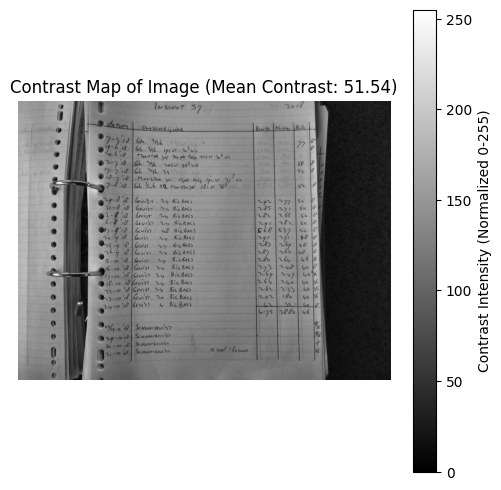

In [38]:
plot_contrast_map(random_image)

### Sharpness

In [39]:
def plot_sharpness_overall(df):
    """
    Plot the distribution of sharpness across the entire dataset.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing sharpness statistics for each image.
    
    Returns:
    None: Displays the sharpness distribution plot for the dataset.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Sharpness'], kde=True, bins=30, color='orange')
    plt.title("Distribution of Sharpness Across Dataset")
    plt.xlabel("Sharpness (Variance of Laplacian)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [40]:
def plot_sharpness_single(image):
    """
    Plot the sharpness histogram for a single image based on edge intensity,
    and display the mean sharpness value in the title.
    
    Parameters:
    image (numpy array): Grayscale image to analyze sharpness distribution.
    
    Returns:
    None: Displays the sharpness histogram for the image.
    """
    # Calculate the mean sharpness using the provided function
    mean_sharpness = calculate_sharpness(image)
    
    # Apply Laplacian to detect edges
    edges = cv2.Laplacian(image, cv2.CV_64F)
    
    plt.figure(figsize=(10, 6))
    plt.hist(np.abs(edges).ravel(), bins=256, range=(0, edges.max()), color='orange', alpha=0.7)
    plt.title(f"Sharpness Histogram of Single Image (Mean Sharpness: {mean_sharpness:.2f})")
    plt.xlabel("Edge Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [41]:
def plot_sharpness_edge_map(image):
    """
    Display an edge map for a single image to visualize areas with high sharpness,
    and display the mean sharpness value in the title.
    
    Parameters:
    image (numpy array): Grayscale image to visualize edge intensity.
    
    Returns:
    None: Displays an edge map visualization of the image.
    """
    # Calculate the mean sharpness using the provided function
    mean_sharpness = calculate_sharpness(image)
    
    # Apply Laplacian to detect edges
    edges = cv2.Laplacian(image, cv2.CV_64F)
    
    # Normalize edges to the range 0-255 for visualization
    edge_map_normalized = cv2.normalize(np.abs(edges), None, 0, 255, cv2.NORM_MINMAX)
    
    # Plot the edge map with the mean sharpness in the title
    plt.figure(figsize=(12, 12))
    plt.imshow(edge_map_normalized, cmap='gray', vmin=0, vmax=255)
    plt.colorbar(label="Edge Intensity (Normalized 0-255)")
    plt.title(f"Edge Map for Sharpness Visualization (Mean Sharpness: {mean_sharpness:.2f})")
    plt.axis('off')
    plt.show()

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


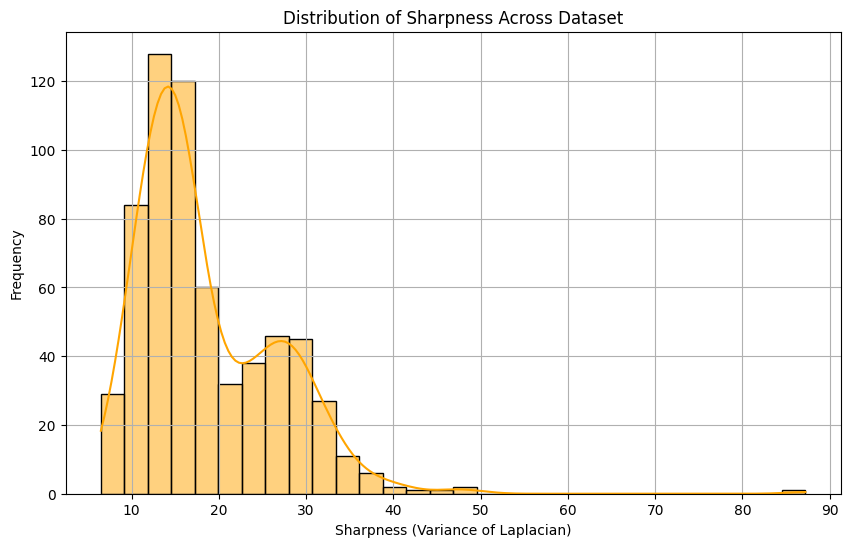

In [42]:
plot_sharpness_overall(df_stats)

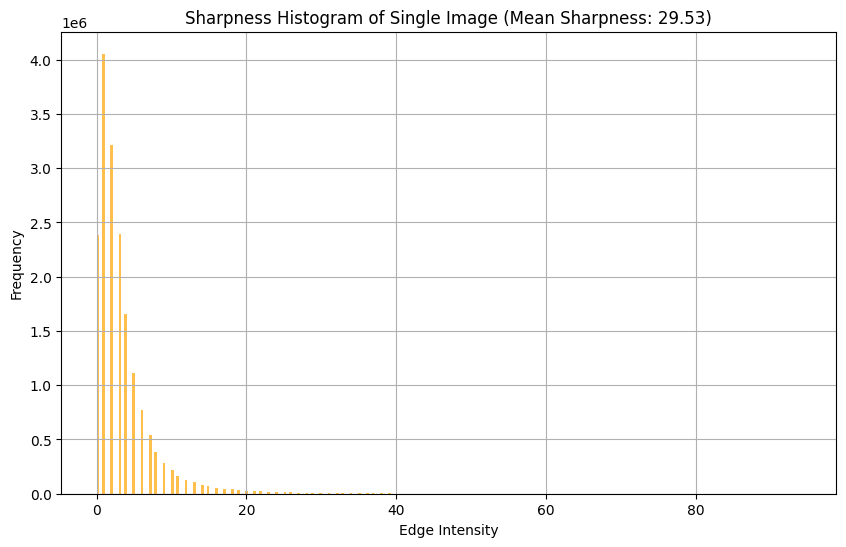

In [43]:
plot_sharpness_single(random_image)

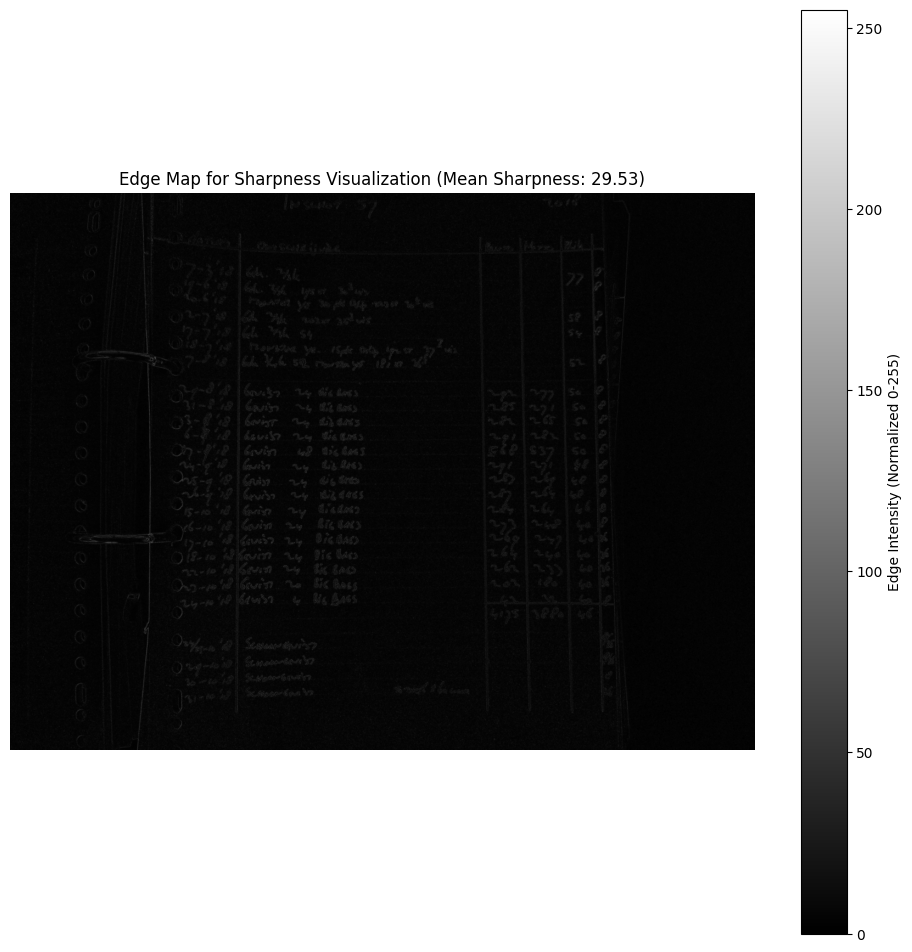

In [44]:
plot_sharpness_edge_map(random_image)

### Noise

In [45]:
def plot_noise_overall(df):
    """
    Plot the distribution of noise across the entire dataset.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing noise statistics for each image.
    
    Returns:
    None: Displays the noise distribution plot for the dataset.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Noise'], kde=True, bins=30, color='red')
    plt.title("Distribution of Noise Across Dataset")
    plt.xlabel("Noise (Pixel Value Std Dev)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [46]:
def plot_noise_single(image):
    """
    Plot the noise histogram for a single image and display the mean noise value.
    
    Parameters:
    image (numpy array): Grayscale image to analyze noise distribution.
    
    Returns:
    None: Displays the noise histogram for the image.
    """
    # Calculate the mean noise using the provided function
    mean_noise = calculate_noise(image)
    
    # Apply Gaussian blur to simulate noise calculation
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    noise = cv2.absdiff(image, blurred_image)
    
    plt.figure(figsize=(10, 6))
    plt.hist(noise.ravel(), bins=256, range=(0, 255), color='red', alpha=0.7)
    plt.title(f"Noise Histogram of Single Image (Mean Noise: {mean_noise:.2f})")
    plt.xlabel("Noise Intensity (Pixel Value)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [47]:
def plot_noise_map(image):
    """
    Display a noise map for a single image by highlighting areas with high noise intensity.
    
    Parameters:
    image (numpy array): Grayscale image to visualize noise intensity.
    
    Returns:
    None: Displays a noise map visualization of the image.
    """
    # Calculate the mean noise using the provided function
    mean_noise = calculate_noise(image)
    
    # Apply Gaussian blur and calculate the difference to highlight noise areas
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    noise_map = cv2.absdiff(image, blurred_image)
    
    # Normalize the noise map to the range 0-255 for visualization
    noise_map_normalized = cv2.normalize(noise_map.astype(np.float64), None, 0, 255, cv2.NORM_MINMAX)
    
    # Plot the noise map with the mean noise in the title
    plt.figure(figsize=(6, 6))
    plt.imshow(noise_map_normalized, cmap='gray', vmin=0, vmax=255)
    plt.colorbar(label="Noise Intensity (Normalized 0-255)")
    plt.title(f"Noise Map of Image (Mean Noise: {mean_noise:.2f})")
    plt.axis('off')
    plt.show()

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


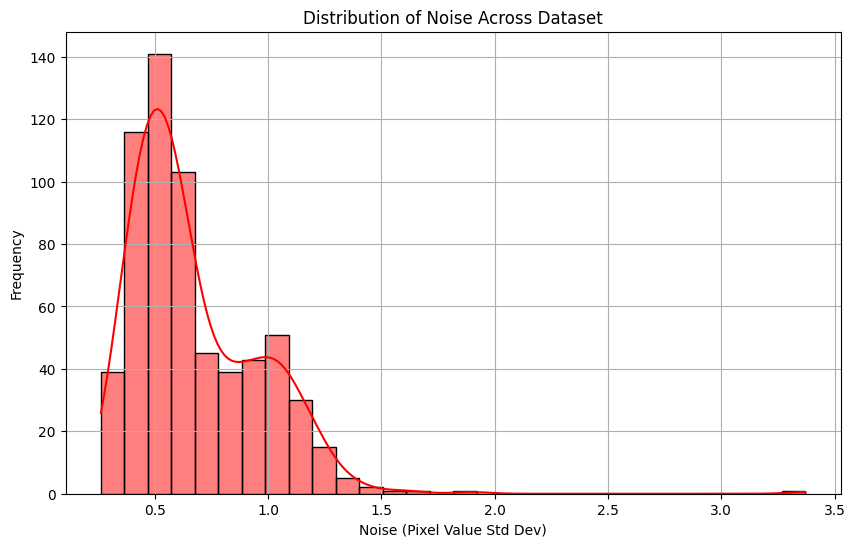

In [48]:
plot_noise_overall(df_stats)

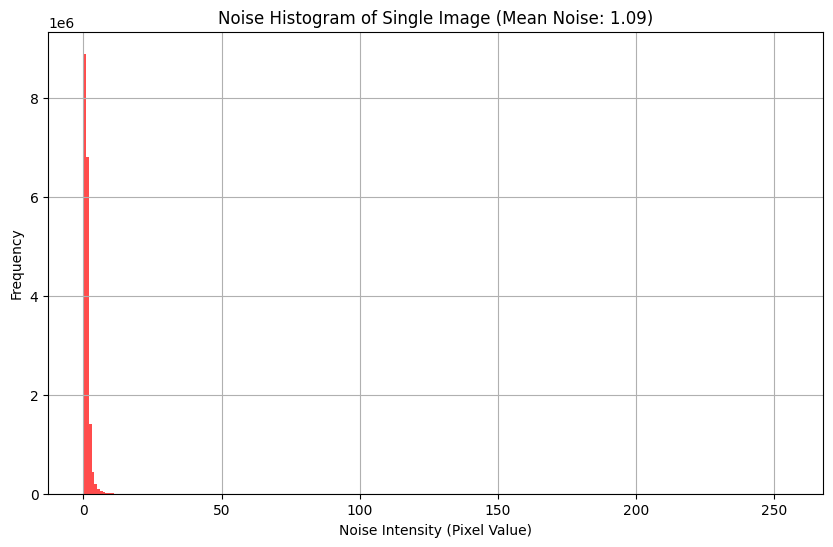

In [49]:
plot_noise_single(random_image)

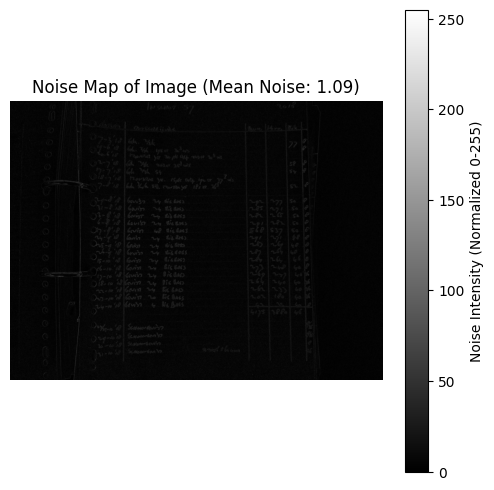

In [50]:
plot_noise_map(random_image)

### Skew

In [51]:
def plot_skew_overall(df):
    """
    Plot the distribution of skew across the entire dataset.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing skew statistics for each image.
    
    Returns:
    None: Displays the skew distribution plot for the dataset.
    """   
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Skew'], kde=True, bins=30, color='green')
    plt.title("Distribution of Skew Across Dataset")
    plt.xlabel("Skew (Degrees)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


In [52]:
def plot_skew_visualization(image):
    """
    Display an image with the skew angle overlay to visualize its orientation.
    
    Parameters:
    image (numpy array): Grayscale image to visualize skew.
    
    Returns:
    None: Displays the image with the skew angle overlay.
    """
    # Calculate the skew angle and detected vertical lines
    skew_angle, vertical_lines = calculate_skew(image)

    # Convert image to color for visualization
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    colors = [(255, 165, 0), (0, 191, 255), (255, 69, 0)]  # Orange, Light Blue, Red-Orange for vertical lines
    
    # Draw the detected vertical lines
    for idx, (x1, y1, x2, y2) in enumerate(vertical_lines):
        color = colors[idx % len(colors)]  # Alternate colors
        cv2.line(output_image, (x1, y1), (x2, y2), color, 8)  # Line thickness increased to 8

    # Draw reference vertical axis
    height, width = image.shape
    cv2.line(output_image, (width // 2, 0), (width // 2, height), (50, 205, 50), 3)  # Lime Green for vertical reference

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Skew Visualization (Angle: {skew_angle:.2f}°)")
    plt.axis('off')
    plt.show()

d:\Software\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


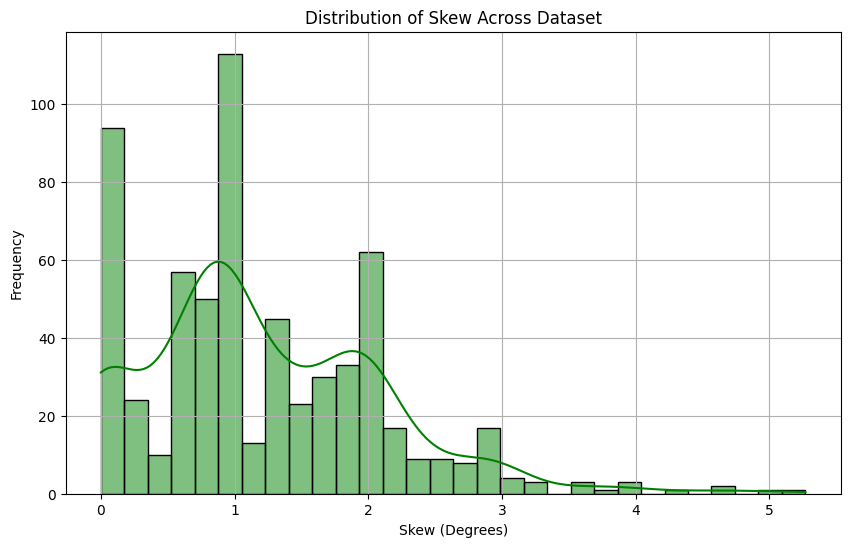

In [53]:
plot_skew_overall(df_stats)

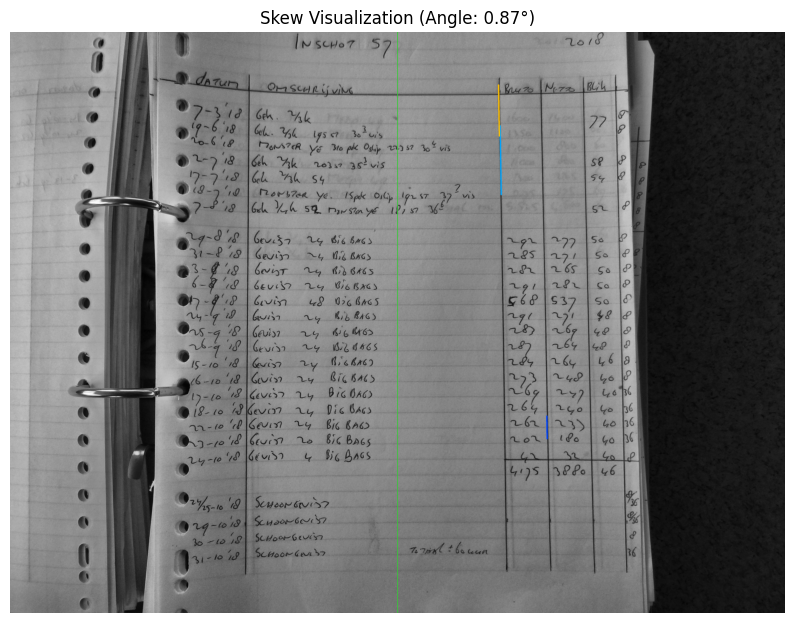

In [54]:
plot_skew_visualization(random_image)